In [48]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import datetime

In [55]:
onboard_rh, onboard_rh_temp, onboard_temp_temp, frame_temp, cpu_temp = [], [], [], [], []
onboard_rh_t, onboard_rh_temp_t, onboard_temp_temp_t, frame_temp_t, cpu_temp_t = [], [], [], [], []
with open('/Users/chasemai/Downloads/MQTT 2/Humidity_Compensation_DC1/logs_1155_20_65/peripheral/onboard/humidity/relative-humidity/relative-humidity-2022-10-03 16_31_37.167097.log', 'r') as onboard_h:
    lines1 = onboard_h.readlines()
for line in lines1:
  onboard_h = json.loads(line.rstrip())
  onboard_rh.append(onboard_h['rh'])
  onboard_rh_t.append(onboard_h['timestamp'])
with open('/Users/chasemai/Downloads/MQTT 2/Humidity_Compensation_DC1/logs_1155_20_65/peripheral/onboard/humidity/temperature/temperature-2022-10-03 16_31_37.167097.log', 'r') as onboard_t:
  lines2 = onboard_t.readlines()
for line in lines2:
  onboard_t = json.loads(line.rstrip())
  onboard_rh_temp.append(onboard_t['celsius'])
  onboard_rh_temp_t.append(onboard_t['timestamp'])
with open('/Users/chasemai/Downloads/MQTT 2/Humidity_Compensation_DC1/logs_1155_20_65/peripheral/onboard/temperature/temperature-2022-10-03 16_31_37.167097.log', 'r') as onboard_t2:
  lines3 = onboard_t2.readlines()
for line in lines3:
  onboard_t2 = json.loads(line.rstrip())
  onboard_temp_temp.append(onboard_t2['celsius'])
  onboard_temp_temp_t.append(onboard_t2['timestamp'])
with open('/Users/chasemai/Downloads/MQTT 2/Humidity_Compensation_DC1/logs_1155_20_65/peripheral/frame/temperature/temperature-2022-10-03 16_31_37.167097.log', 'r') as frame_t:
  lines4 = frame_t.readlines()
for line in lines4:
  frame_t = json.loads(line.rstrip())
  frame_temp.append(frame_t['celsius'])
  frame_temp_t.append(frame_t['timestamp'])
with open('/Users/chasemai/Downloads/MQTT 2/Humidity_Compensation_DC1/logs_1155_20_65/peripheral/cpu/temperature/temperature-2022-10-03 16_31_37.167097.log', 'r') as cpu_t:
 lines5 = cpu_t.readlines()
for line in lines5:
  cpu_t = json.loads(line.rstrip())
  cpu_temp.append(cpu_t['celsius'])
  cpu_temp_t.append(cpu_t['timestamp'])

<Figure size 2000x1000 with 0 Axes>

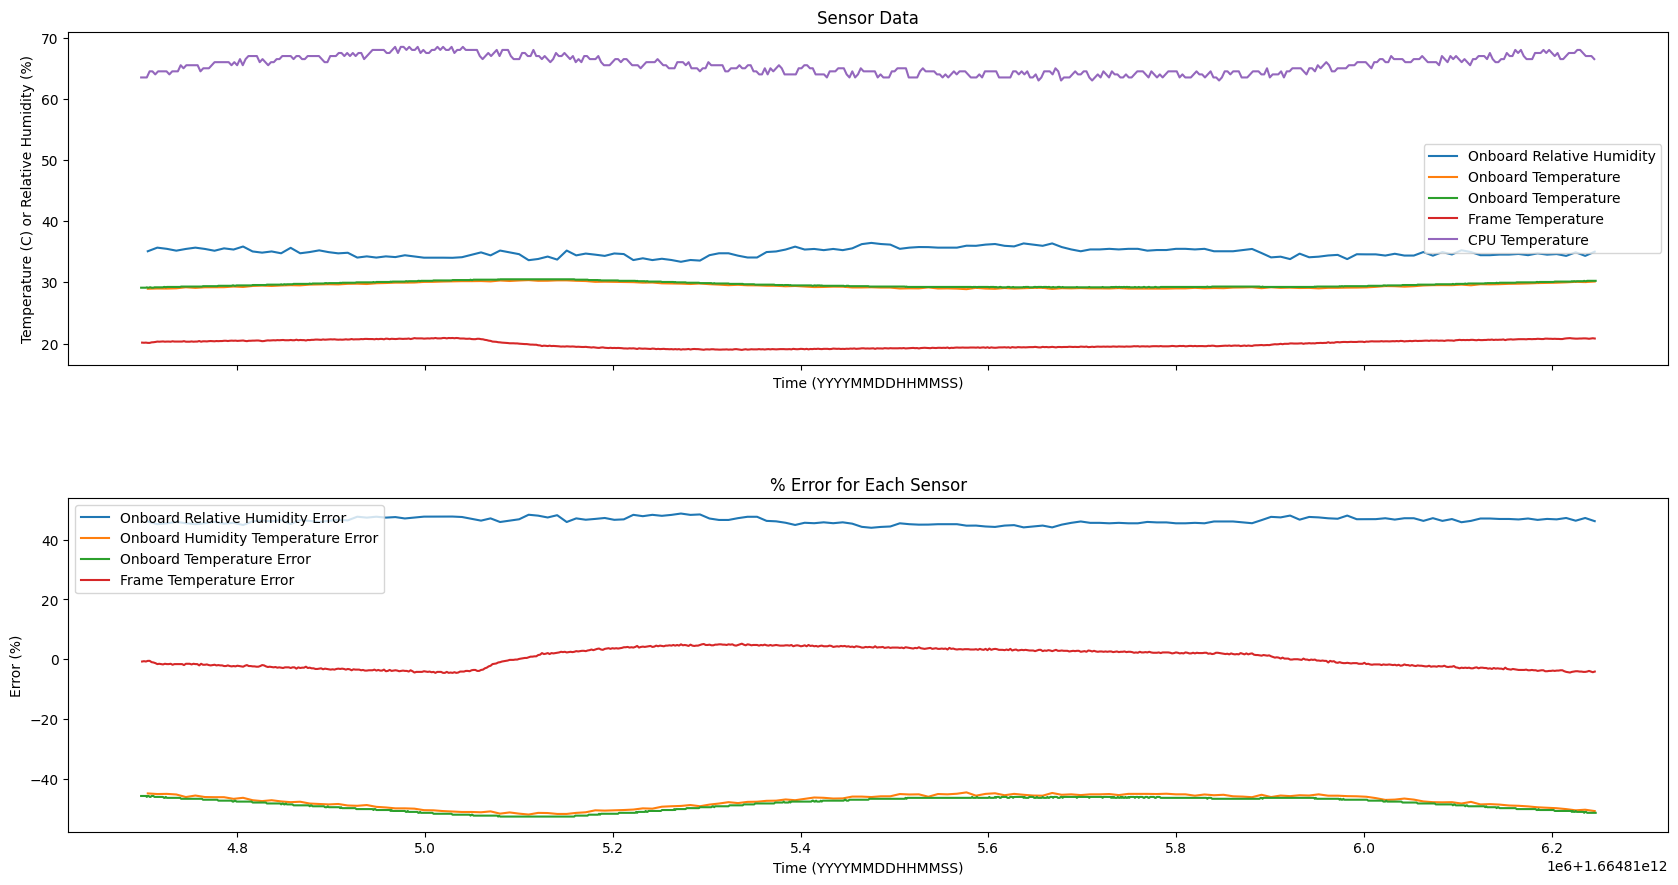

In [62]:
plt.figure(figsize=(20,10))
plt.clf() # reset plot window
fig , ax = plt.subplots(2,1, figsize=(20,10), sharex=True, sharey=False) # two rows, one col
ax[0].set_title("Sensor Data")
ax[0].set_xlabel("Time (YYYYMMDDHHMMSS)")
ax[0].set_ylabel("Temperature (C) or Relative Humidity (%)")
ax[0].plot(onboard_rh_t, onboard_rh, label="Onboard Relative Humidity")
ax[0].plot(onboard_rh_temp_t, onboard_rh_temp, label="Onboard Temperature")
ax[0].plot(onboard_temp_temp_t, onboard_temp_temp, label="Onboard Temperature")
ax[0].plot(frame_temp_t, frame_temp, label="Frame Temperature")
ax[0].plot(cpu_temp_t, cpu_temp, label="CPU Temperature")
ax[0].legend()

# % error = 1- (part/whole)
ax[1].set_title("% Error for Each Sensor")
ax[1].set_xlabel("Time (YYYYMMDDHHMMSS)")
ax[1].set_ylabel("Error (%)")
ax[1].plot(onboard_rh_t, 100 *(1 - np.array(onboard_rh)/65), label="Onboard Relative Humidity Error")
ax[1].plot(onboard_rh_temp_t, 100 * (1 - np.array(onboard_rh_temp)/20), label="Onboard Humidity Temperature Error")
ax[1].plot(onboard_temp_temp_t, 100 *(1 - np.array(onboard_temp_temp)/20), label="Onboard Temperature Error")
ax[1].plot(frame_temp_t, 100 *(1 - np.array(frame_temp)/20), label="Frame Temperature Error")
# ax[1].plot(cpu_temp_t, 100 *(1 - np.array(cpu_temp)/20), label="CPU Temperature Error")
ax[1].legend()
plt.subplots_adjust(left=0.1,
            bottom=0.1, 
            right=0.9, 
            top=0.9, 
            wspace=0.4, 
            hspace=0.4)
plt.show()


In [63]:
# use a regression model from sklearn on to predict the relative humidity from the onboard temperature
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(onboard_rh_temp).reshape(-1,1), np.array(onboard_rh).reshape(-1,1), test_size=0.2, random_state=42)


In [64]:
lg = LinearRegression().fit(X_train, y_train)
y_pred = lg.predict(X_test)
# calculcate the mean squared error of the predictions
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# calculate the coefficient of determination (R^2) of the predictions
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))


Mean squared error: 0.24
Coefficient of determination: 0.54


In [66]:
def get_loss(X, y, W):
    loss = np.matmul(np.transpose(y-np.matmul(X,W)),(y-np.matmul(X,W))) / len(y) # -- Code Required --
    return loss

In [65]:
def OLS(X, y):

    W = np.linalg.solve(np.matmul(np.transpose(X),X), np.matmul(np.transpose(X),y)) # -- Code Required --

    return W

W_ols = OLS(X_train, y_train)
print("W_ols:", W_ols)

W_ols: [[1.18318742]]


In [69]:
loss_train = get_loss(X_train, y_train, W_ols) # -- Code Required --
loss_test = get_loss(X_test, y_test, W_ols) # -- Code Required --

print("Training Loss:", loss_train)
print("Testing Loss:", loss_test) 

Training Loss: [[1.18783014]]
Testing Loss: [[1.29916961]]


In [72]:
def get_ridge_loss(X, y, W, lmda):
    loss = np.matmul(np.transpose(y-np.matmul(X,W)),(y-np.matmul(X,W))) / len(y) + (lmda * np.matmul(np.transpose(W),W)) 
    return loss

In [73]:
def ridge(X, y, lmda):
    bg = np.matmul(np.transpose(X), X)
    W = np.linalg.solve(np.dot(np.transpose(X),X) + lmda * np.identity(bg.shape[0]), np.dot(np.transpose(X),y))# -- Code Required --
    
    return W

lmda = 0.1
W_ridge = ridge(X_train, y_train, lmda)
print("W_ridge:", W_ridge)

W_ridge: [[1.1831863]]


In [74]:
loss_train = get_ridge_loss(X_train, y_train, W_ridge, lmda)# -- Code Required --
loss_test = get_ridge_loss(X_test, y_test, W_ridge, lmda) # -- Code Required --

print("Training Loss:", loss_train)
print("Testing Loss:", loss_test)

Training Loss: [[1.32782312]]
Testing Loss: [[1.43916762]]


In [79]:
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True) 
train_loss_arr = []
val_loss_arr = []
lmdas = []
#np.linspace(10,100,10,endpoint=True)
count = 0
for i in range(-20,0):
  lmda = 10**i
  lmdas.append(lmda)
  W_ridge = ridge(X_train, y_train, lmdas[count])
  train_loss_arr.append(get_loss(X_train,y_train,W_ridge))
  val_loss_arr.append(get_loss(xval,yval,W_ridge))
  count += 1
print(lmdas)
print(train_loss_arr)
print(val_loss_arr)
loss_train = get_loss(X_train,y_train,W_ols) # -- Code Required --
#W_val = OLS(xval, yval)
loss_val = get_loss(xval,yval,W_ols) # -- Code Required --
#W_tst = OLS(xtest,ytest)
loss_test = get_loss(X_test,y_test,W_ols) # -- Code Required --

print("Training Loss:", loss_train)
print("Validation Loss:", loss_val)
print("Testing Loss:", loss_test)

[1e-20, 1e-19, 1e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
[array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]]), array([[1.18783014]])]
[array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347157]]), array([[1.02347156]]), array([[1.02347154]]), array([[

In [84]:
# Identifying lambda_star
min_index = np.argmin(val_loss_arr)
lmda_star = lmdas[min_index]

# Creating final xtrain and ytrain
xtrain_final = np.vstack((X_train, xval)) 
ytrain_final = np.hstack((y_train, yval)) 

# Calculating W_ridge_star
W_ridge_star = ridge(xtrain_final, ytrain_final, lmda_star)

print("lmda_star:", lmda_star)
print("W_ridge_star:", W_ridge_star[:10]) # For the sake of cleanliness we will only print first 10 coefficients

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 122 and the array at index 1 has size 31